- import cleansed_timestamps.csv

In [1]:
import pandas as pd

# Specify the file path
file_path = r"C:\Users\cpall\OneDrive\Corsi\2025_corso_Bootcamp\mini_project5_ab_testing\cleansed_timestamps.csv"

# Read the txt file into a DataFrame
df_ts = pd.read_csv(file_path, sep=",")  # comma-separated values
# Display basic information about the dataframe
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56113 entries, 0 to 56112
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               56113 non-null  int64  
 1   visitor_id              56113 non-null  object 
 2   visit_id                56113 non-null  object 
 3   delta_start_to_step1    43349 non-null  float64
 4   delta_step1_to_step2    37894 non-null  float64
 5   delta_step2_to_step3    35481 non-null  float64
 6   delta_step3_to_confirm  31918 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.0+ MB


In [2]:
print("Unique clients:", df_ts['client_id'].nunique())

Unique clients: 45866


In [3]:
# Convert IDs to strings to avoid concatenation issues
df_ts['client_id'] = df_ts['client_id'].astype(str)
df_ts['visit_id']  = df_ts['visit_id'].astype(str)

# Create a session-level primary key
df_ts['session_id'] = (
    df_ts['client_id'] + "_" + df_ts['visit_id']
)

# Check: number of unique sessions
print("Unique sessions:", df_ts['session_id'].nunique())
print("Rows:", len(df_ts))

Unique sessions: 56113
Rows: 56113


- import df_ab_project.csv

In [4]:
# Specify the file path
file_path = r"C:\Users\cpall\OneDrive\Corsi\2025_corso_Bootcamp\mini_project5_ab_testing\df_ab_project.csv"

# Read the txt file into a DataFrame
full_merged_exp_demo = pd.read_csv(file_path, sep=",")  # comma-separated values
# Display basic information about the dataframe
full_merged_exp_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321195 entries, 0 to 321194
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         321195 non-null  int64  
 1   visitor_id        321195 non-null  object 
 2   visit_id          321195 non-null  object 
 3   process_step      321195 non-null  object 
 4   date_time         321195 non-null  object 
 5   variation         321195 non-null  object 
 6   clnt_tenure_yr    321195 non-null  float64
 7   clnt_tenure_mnth  321195 non-null  float64
 8   clnt_age          321195 non-null  float64
 9   gendr             321195 non-null  object 
 10  num_accts         321195 non-null  float64
 11  bal               321195 non-null  float64
 12  calls_6_mnth      321195 non-null  float64
 13  logons_6_mnth     321195 non-null  float64
 14  session_id        321195 non-null  object 
 15  gender_clean      212303 non-null  object 
dtypes: float64(7), int64

In [5]:
# Check: number of unique sessions
print("Unique sessions:", full_merged_exp_demo['session_id'].nunique())
print("Unique clients:", full_merged_exp_demo['client_id'].nunique())

Unique sessions: 69425
Unique clients: 50487


In [6]:
# Collapse full_merged_exp_demo to session-level only (critical):
# it is organised as process-step level, i.e. one session appears multiple times.
# Before merge, keep only one row per session (first observation is enough because variation & demographics don’t change within session).
cols_to_drop = [
    "client_id", "visitor_id", "visit_id",
    "process_step", "date_time"
]

df_ab_session = (
    full_merged_exp_demo
        .sort_values("date_time")
        .drop(columns=cols_to_drop)
        .drop_duplicates(subset="session_id", keep="first")
)


In [ ]:
# Inner join on session_id
df_final = df_ts.merge(
    df_ab_session,
    how="inner",
    on="session_id",
    validate="one_to_one"
)

# Check final dataframe
df_final.info()
print("Rows after merge:", df_final.shape[0])
print("Unique sessions:", df_final["session_id"].nunique())
print("Unique clients:", df_final["client_id"].nunique())
print("Missing keys:", df_final["session_id"].isna().sum())
# Save final dataframe to CSV
df_final.to_csv("ab_test_session_level_dataset.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56113 entries, 0 to 56112
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               56113 non-null  object 
 1   visitor_id              56113 non-null  object 
 2   visit_id                56113 non-null  object 
 3   delta_start_to_step1    43349 non-null  float64
 4   delta_step1_to_step2    37894 non-null  float64
 5   delta_step2_to_step3    35481 non-null  float64
 6   delta_step3_to_confirm  31918 non-null  float64
 7   session_id              56113 non-null  object 
 8   variation               56113 non-null  object 
 9   clnt_tenure_yr          56113 non-null  float64
 10  clnt_tenure_mnth        56113 non-null  float64
 11  clnt_age                56113 non-null  float64
 12  gendr                   56113 non-null  object 
 13  num_accts               56113 non-null  float64
 14  bal                     56113 non-null

#### Hipotesis 1 KPI1 – Completion proportion by Variation (one-sided)


Completion counts and percentages by variation:
  variation  completed  count  percentage
0   control      False  13754       49.00
1   control       True  14318       51.00
2      test      False  10441       37.23
3      test       True  17600       62.77

Contingency Table:
completed  Not Completed  Completed
variation                          
control            13754      14318
test               10441      17600

One-sided Fisher's Exact Test p-value: 0.0000
Odds Ratio: 1.6193
Result: Statistically significant higher completion rate in test group.

Contingency Table with OR, Fisher p-value, and % of total sessions:
completed  Not Completed  % Not Completed  Completed  % Completed  Total  \
variation                                                                  
control            13754            49.00      14318        51.00  28072   
test               10441            37.23      17600        62.77  28041   

completed  % of Total Sessions Odds Ratio (Test vs Control) p-val

C:\Users\cpall\AppData\Local\Temp\ipykernel_29692\1784275560.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variation', y='% Completed', data=plot_df, palette=['#4C72B0','#55A868'])


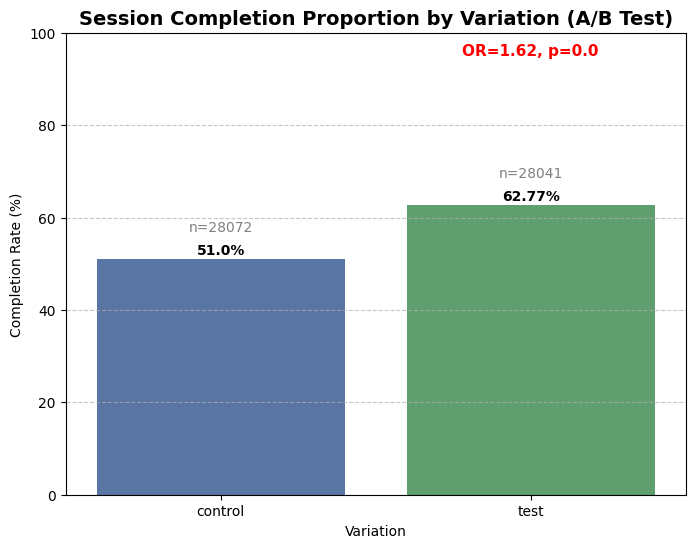

In [66]:
#  Hipotesis 1 KPI1 – Completion proportion by Variation (one-sided)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact

# Define completion at session level
df_final["completed"] = df_final["delta_step3_to_confirm"].notna()

# KPI1 – Completion proportion by Variation
completion_by_group = (
    df_final
        .groupby(["variation", "completed"])
        .size()
        .reset_index(name="count")
)

completion_by_group["percentage"] = (
    completion_by_group
        .groupby("variation")["count"]
        .transform(lambda x: round(100 * x / x.sum(), 2))
)

print("\nCompletion counts and percentages by variation:")
print(completion_by_group)

# Fisher contingency table
contingency_table = (
    completion_by_group
        .pivot(index="variation", columns="completed", values="count")
        .fillna(0)
        .rename(columns={False: "Not Completed", True: "Completed"})
)

table_for_test = [
    contingency_table.loc["control", ["Not Completed", "Completed"]].tolist(),
    contingency_table.loc["test",    ["Not Completed", "Completed"]].tolist()
]

print("\nContingency Table:")
print(contingency_table)

# Fisher's Exact Test (one-sided, test > control)
odds_ratio, p_value = fisher_exact(table_for_test, alternative='greater')
print(f"\nOne-sided Fisher's Exact Test p-value: {p_value:.4f}")
print(f"Odds Ratio: {odds_ratio:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant higher completion rate in test group.")

# Final reporting table
contingency_table["Odds Ratio (Test vs Control)"] = ""
contingency_table["p-value"] = ""
contingency_table.loc["control", "Odds Ratio (Test vs Control)"] = 1.00
contingency_table.loc["test",    "Odds Ratio (Test vs Control)"] = round(odds_ratio, 2)
contingency_table.loc["test",    "p-value"] = round(p_value, 3)

contingency_table["Total"] = contingency_table["Not Completed"] + contingency_table["Completed"]
contingency_table["% Not Completed"] = round(100 * contingency_table["Not Completed"] / contingency_table["Total"], 2)
contingency_table["% Completed"] = round(100 * contingency_table["Completed"] / contingency_table["Total"], 2)
total_sessions = contingency_table["Total"].sum()
contingency_table["% of Total Sessions"] = round(100 * contingency_table["Total"] / total_sessions, 2)

contingency_table_final = contingency_table[
    ["Not Completed", "% Not Completed",
     "Completed", "% Completed",
     "Total", "% of Total Sessions",
     "Odds Ratio (Test vs Control)", "p-value"]
]

print("\nContingency Table with OR, Fisher p-value, and % of total sessions:")
print(contingency_table_final)

# Plotting
plot_df = contingency_table_final.reset_index()  # bring 'variation' back as a column
plt.figure(figsize=(8,6))
sns.barplot(x='variation', y='% Completed', data=plot_df, palette=['#4C72B0','#55A868'])

# Add text labels for completion %
for idx, row in plot_df.iterrows():
    plt.text(idx, row['% Completed'] + 1, f"{row['% Completed']}%", ha='center', fontweight='bold')
    plt.text(idx, row['% Completed'] + 6, f"n={row['Total']}", ha='center', color='gray')

plt.title("Session Completion Proportion by Variation (A/B Test)", fontsize=14, fontweight='bold')
plt.ylabel("Completion Rate (%)")
plt.ylim(0, 100)
plt.xlabel("Variation")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Odds Ratio and p-value for the Test group
test_row = plot_df[plot_df['variation']=='test'].iloc[0]
plt.text(1, 95, f"OR={test_row['Odds Ratio (Test vs Control)']}, p={test_row['p-value']}", 
         ha='center', fontsize=11, fontweight='bold', color='red')

plt.show()


In [ ]:
# Calculate the observed increase in completion rate
control_completed_pct = contingency_table_final.loc['control', '% Completed']
test_completed_pct    = contingency_table_final.loc['test', '% Completed']

# Calculate absolute increase
delta_completion = test_completed_pct - control_completed_pct
print(f"Observed increase in completion rate: {delta_completion:.2f}%")


Observed increase in completion rate: 11.77%



Observed increase in completion rate: 11.77%
The observed increase (11.77%) meets or exceeds the cost-effectiveness threshold of 5.0%.


C:\Users\cpall\AppData\Local\Temp\ipykernel_29692\127182127.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variation', y='% Completed', data=plot_df, palette=['#4C72B0','#55A868'])


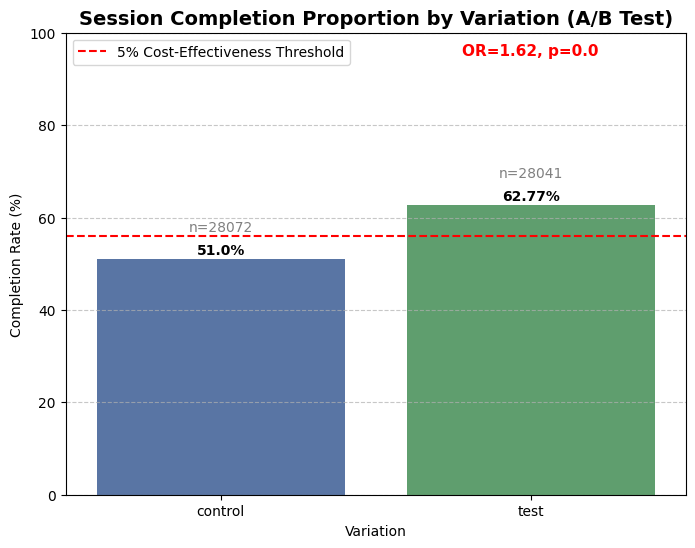

In [ ]:
# Cost-Effectiveness Threshold Analysis
control_completed_pct = contingency_table_final.loc['control', '% Completed']
test_completed_pct    = contingency_table_final.loc['test', '% Completed']

# Calculate absolute increase
delta_completion = test_completed_pct - control_completed_pct
print(f"\nObserved increase in completion rate: {delta_completion:.2f}%")

# Define threshold
threshold = 5.0

if delta_completion >= threshold:
    print(f"The observed increase ({delta_completion:.2f}%) meets or exceeds the cost-effectiveness threshold of {threshold}%.")
else:
    print(f"The observed increase ({delta_completion:.2f}%) does NOT meet the cost-effectiveness threshold of {threshold}%.")

# Plotting
plot_df = contingency_table_final.reset_index()  # bring 'variation' back as a column
plt.figure(figsize=(8,6))
sns.barplot(x='variation', y='% Completed', data=plot_df, palette=['#4C72B0','#55A868'])

# Add text labels for completion %
for idx, row in plot_df.iterrows():
    plt.text(idx, row['% Completed'] + 1, f"{row['% Completed']}%", ha='center', fontweight='bold')
    plt.text(idx, row['% Completed'] + 6, f"n={row['Total']}", ha='center', color='gray')

# Add threshold line
plt.axhline(y=control_completed_pct + threshold, color='red', linestyle='--', linewidth=1.5, label=f"5% Cost-Effectiveness Threshold")
plt.legend()

plt.title("Session Completion Proportion by Variation (A/B Test)", fontsize=14, fontweight='bold')
plt.ylabel("Completion Rate (%)")
plt.ylim(0, 100)
plt.xlabel("Variation")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Odds Ratio and p-value for Test group
test_row = plot_df[plot_df['variation']=='test'].iloc[0]
plt.text(1, 95, f"OR={test_row['Odds Ratio (Test vs Control)']}, p={test_row['p-value']}", 
         ha='center', fontsize=11, fontweight='bold', color='red')

plt.show()


In [12]:
# # KPI2 – Time Spent on Each Step
delta_cols = [
    "delta_start_to_step1",
    "delta_step1_to_step2",
    "delta_step2_to_step3",
    "delta_step3_to_confirm"
]

# Compute mean time per step by variation
delta_avg = df_final.groupby("variation")[delta_cols].mean().round(2)

# Optional: convert to seconds/minutes if needed (depends on your delta units)
print("\nAverage Time Spent on Each Step by Variation (in original units):")
print(delta_avg)



Average Time Spent on Each Step by Variation (in original units):
           delta_start_to_step1  delta_step1_to_step2  delta_step2_to_step3  \
variation                                                                     
control                   50.76                 50.66                 97.39   
test                      45.30                 46.86                 99.28   

           delta_step3_to_confirm  
variation                          
control                    135.50  
test                       143.04  


In [ ]:
# Reshape for plotting
delta_avg_plot = delta_avg.reset_index().melt(id_vars="variation", 
                                              value_vars=delta_cols, 
                                              var_name="Step", 
                                              value_name="Avg Duration")

# make step names more readable
delta_avg_plot["Step"] = delta_avg_plot["Step"].str.replace("delta_", "").str.replace("_", " ").str.title()


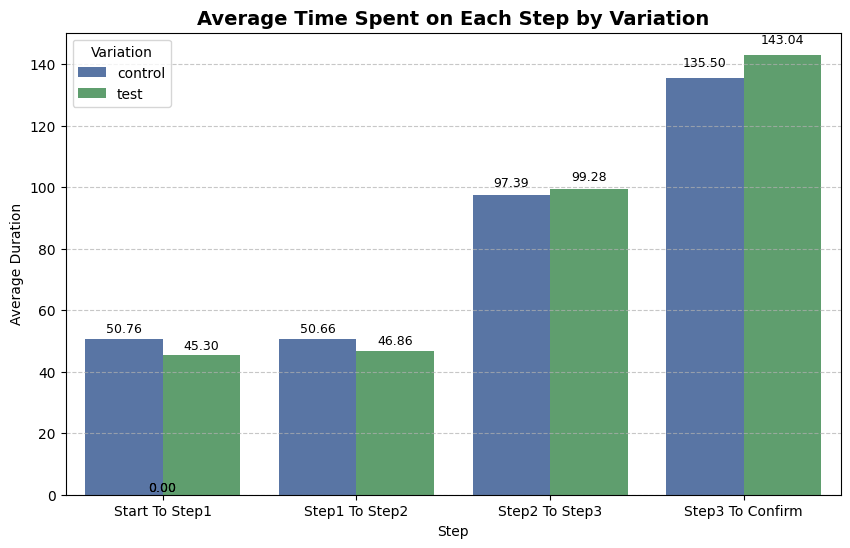

In [14]:
# Plot average duration per step
plt.figure(figsize=(10,6))
sns.barplot(data=delta_avg_plot, x="Step", y="Avg Duration", hue="variation", palette=['#4C72B0','#55A868'])

# Annotate bars with values
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2, height + 0.02*height, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=9)

plt.title("Average Time Spent on Each Step by Variation", fontsize=14, fontweight='bold')
plt.ylabel("Average Duration")
plt.xlabel("Step")
plt.legend(title="Variation")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\cpall\AppData\Local\Temp\ipykernel_29692\3542925121.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


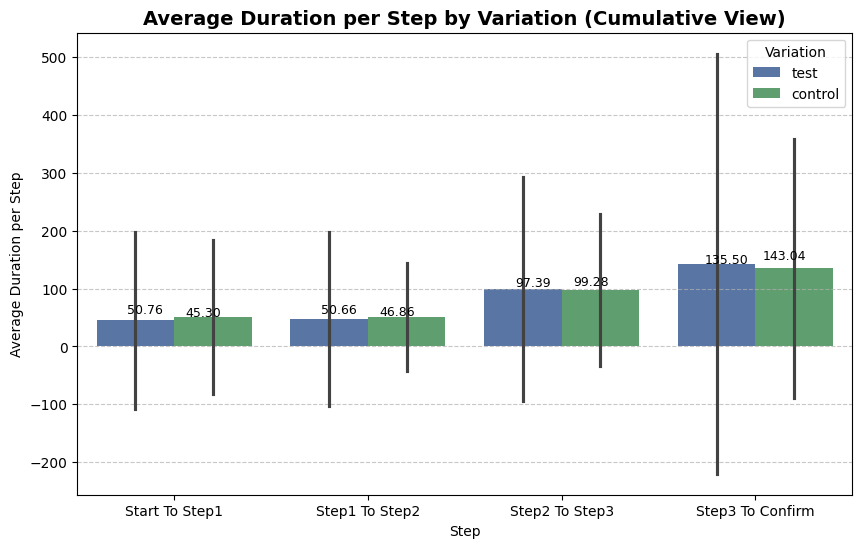

In [ ]:

# Compute cumulative sum per session
df_final["total_time"] = df_final[delta_cols].sum(axis=1, skipna=True)
# Melt for step-level plotting
df_cum_plot = df_final.melt(
    id_vars=["variation", "session_id"], 
    value_vars=delta_cols,
    var_name="Step", 
    value_name="Duration"
)

# Make step names readable
df_cum_plot["Step"] = df_cum_plot["Step"].str.replace("delta_", "").str.replace("_", " ").str.title()

# Plot cumulative time per step (average per variation)
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_cum_plot, 
    x="Step", 
    y="Duration", 
    hue="variation", 
    ci="sd",  # show variability
    palette=['#4C72B0','#55A868']
)

plt.title("Average Duration per Step by Variation (Cumulative View)", fontsize=14, fontweight='bold')
plt.ylabel("Average Duration per Step")
plt.xlabel("Step")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate average durations
step_means = df_cum_plot.groupby(["variation","Step"])["Duration"].mean().round(2).reset_index()
for idx, row in step_means.iterrows():
    x_pos = list(df_cum_plot["Step"].unique()).index(row["Step"])
    offset = -0.15 if row["variation"] == "control" else 0.15
    plt.text(x_pos + offset, row["Duration"] + 0.02*row["Duration"], f"{row['Duration']:.2f}", 
             ha='center', va='bottom', fontsize=9)

plt.legend(title="Variation")
plt.show()


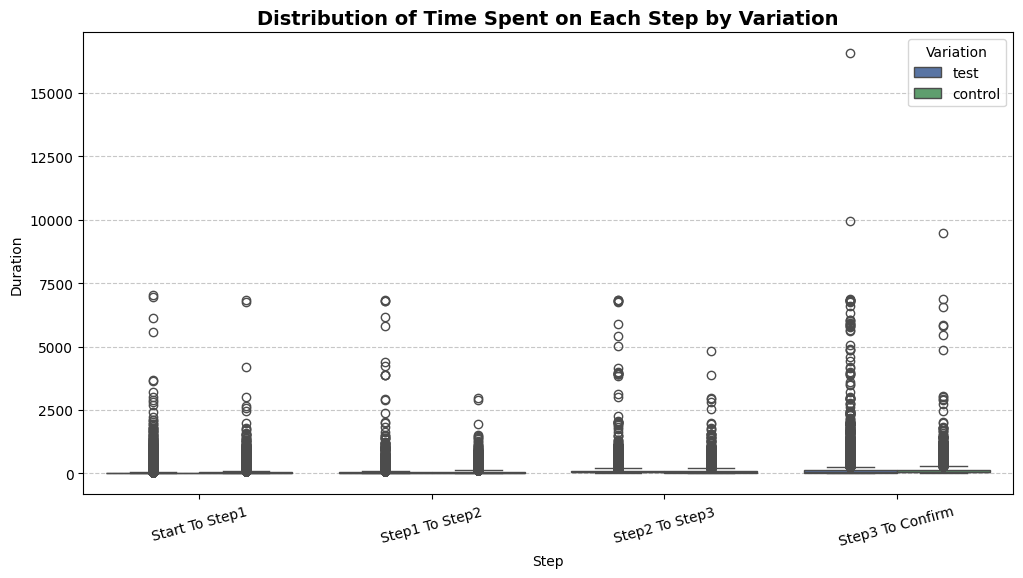

In [16]:
# Prepare the data for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Select delta columns
delta_cols = [
    "delta_start_to_step1",
    "delta_step1_to_step2",
    "delta_step2_to_step3",
    "delta_step3_to_confirm"
]

# Melt for plotting
df_box = df_final.melt(
    id_vars=["variation"], 
    value_vars=delta_cols, 
    var_name="Step", 
    value_name="Duration"
)

# Make step names readable
df_box["Step"] = df_box["Step"].str.replace("delta_", "").str.replace("_", " ").str.title()

# Plot boxplots per step and variation
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_box, 
    x="Step", 
    y="Duration", 
    hue="variation", 
    palette=['#4C72B0','#55A868']
)

plt.title("Distribution of Time Spent on Each Step by Variation", fontsize=14, fontweight='bold')
plt.ylabel("Duration")
plt.xlabel("Step")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Variation")
plt.xticks(rotation=15)
plt.show()


In [18]:
# IQR outlier detection per variation group
delta_cols = [
    "delta_start_to_step1",
    "delta_step1_to_step2",
    "delta_step2_to_step3",
    "delta_step3_to_confirm"
]

outlier_info = []

for group in df_final["variation"].unique():

    df_group = df_final[df_final["variation"] == group]

    for col in delta_cols:
        data = df_group[col].dropna()

        if len(data) == 0:
            continue

        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        lower_cutoff = Q1 - 1.5 * IQR
        upper_cutoff = Q3 + 1.5 * IQR

        num_outliers = ((data < lower_cutoff) | (data > upper_cutoff)).sum()

        outlier_info.append({
            "Variation Group": group,
            "Delta": col,
            "Q1": round(Q1, 2),
            "Q3": round(Q3, 2),
            "IQR": round(IQR, 2),
            "Lower Cutoff": round(lower_cutoff, 2),
            "Upper Cutoff": round(upper_cutoff, 2),
            "Num Outliers": num_outliers
        })

outlier_df = pd.DataFrame(outlier_info)
print(outlier_df)


  Variation Group                   Delta    Q1     Q3    IQR  Lower Cutoff  \
0            test    delta_start_to_step1   6.0   28.5   22.5        -27.75   
1            test    delta_step1_to_step2  13.0   44.0   31.0        -33.50   
2            test    delta_step2_to_step3  42.0  107.0   65.0        -55.50   
3            test  delta_step3_to_confirm  32.0  129.0   97.0       -113.50   
4         control    delta_start_to_step1   9.0   44.0   35.0        -43.50   
5         control    delta_step1_to_step2   9.0   54.0   45.0        -58.50   
6         control    delta_step2_to_step3  39.0  114.0   75.0        -73.50   
7         control  delta_step3_to_confirm  44.0  148.0  104.0       -112.00   

   Upper Cutoff  Num Outliers  
0         62.25          3447  
1         90.50          1720  
2        204.50          1432  
3        274.50          2000  
4         96.50          2117  
5        121.50          1662  
6        226.50          1132  
7        304.00          1359  


In [62]:
# IQR outlier detection per variation group with % of outliers
delta_cols = [
    "delta_start_to_step1",
    "delta_step1_to_step2",
    "delta_step2_to_step3",
    "delta_step3_to_confirm"
]

outlier_info = []

for group in df_final["variation"].unique():
    df_group = df_final[df_final["variation"] == group]

    for col in delta_cols:
        data = df_group[col].dropna()
        n_total = len(data)

        if n_total == 0:
            continue

        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        lower_cutoff = Q1 - 1.5 * IQR
        upper_cutoff = Q3 + 1.5 * IQR

        num_outliers = ((data < lower_cutoff) | (data > upper_cutoff)).sum()
        pct_outliers = round(100 * num_outliers / n_total, 2)

        outlier_info.append({
            "Variation Group": group,
            "Delta": col,
            "Q1": round(Q1, 2),
            "Q3": round(Q3, 2),
            "IQR": round(IQR, 2),
            "Lower Cutoff": round(lower_cutoff, 2),
            "Upper Cutoff": round(upper_cutoff, 2),
            "Num Outliers": num_outliers,
            "% Outliers": pct_outliers
        })

outlier_df = pd.DataFrame(outlier_info)
print(outlier_df)


  Variation Group                   Delta    Q1     Q3    IQR  Lower Cutoff  \
0            test    delta_start_to_step1   6.0   28.5   22.5        -27.75   
1            test    delta_step1_to_step2  13.0   44.0   31.0        -33.50   
2            test    delta_step2_to_step3  42.0  107.0   65.0        -55.50   
3            test  delta_step3_to_confirm  32.0  129.0   97.0       -113.50   
4         control    delta_start_to_step1   9.0   44.0   35.0        -43.50   
5         control    delta_step1_to_step2   9.0   54.0   45.0        -58.50   
6         control    delta_step2_to_step3  39.0  114.0   75.0        -73.50   
7         control  delta_step3_to_confirm  44.0  148.0  104.0       -112.00   

   Upper Cutoff  Num Outliers  % Outliers  
0         62.25          3447       15.05  
1         90.50          1720        8.47  
2        204.50          1432        7.45  
3        274.50          2000       11.36  
4         96.50          2117       10.36  
5        121.50         

In [19]:
# Remove outliers per variation & per delta column
delta_cols = [
    "delta_start_to_step1",
    "delta_step1_to_step2",
    "delta_step2_to_step3",
    "delta_step3_to_confirm"
]

df_clean = df_final.copy()

for variation in df_clean["variation"].unique():
    
    df_var = df_clean[df_clean["variation"] == variation]

    for col in delta_cols:
        data = df_var[col].dropna()

        if len(data) == 0:
            continue

        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        lower_cutoff = Q1 - 1.5 * IQR
        upper_cutoff = Q3 + 1.5 * IQR

        mask = (
            (df_clean["variation"] == variation) &
            ((df_clean[col] < lower_cutoff) | (df_clean[col] > upper_cutoff))
        )

        # Replace outliers with NaN instead of dropping rows
        df_clean.loc[mask, col] = np.nan


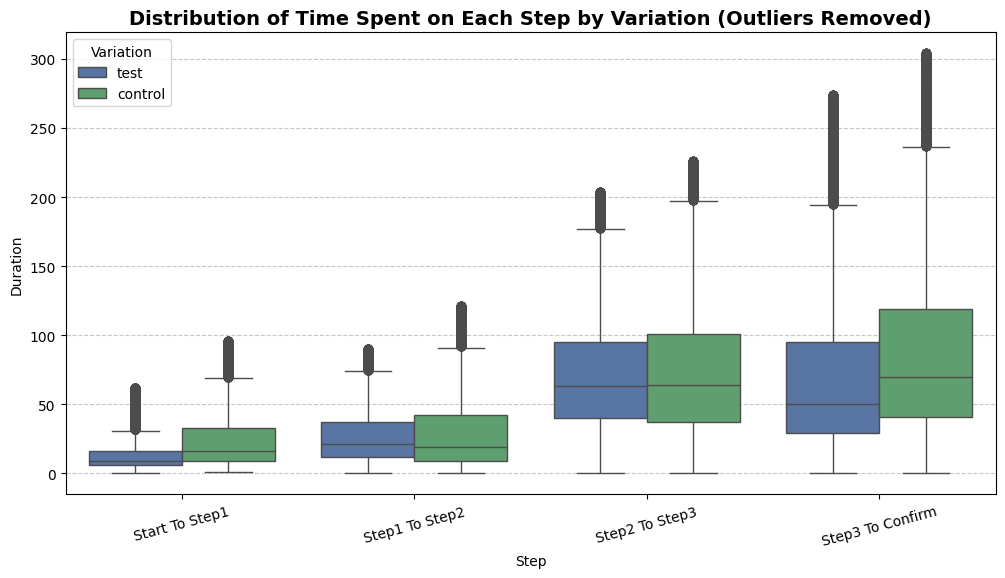

In [20]:
# Prepare cleaned data for boxplot
df_box = df_clean.melt(
    id_vars=["variation"],
    value_vars=delta_cols,
    var_name="Step",
    value_name="Duration"
)

df_box["Step"] = (
    df_box["Step"]
    .str.replace("delta_", "", regex=False)
    .str.replace("_", " ", regex=False)
    .str.title()
)

# Boxplot using cleaned data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_box,
    x="Step",
    y="Duration",
    hue="variation",
    palette=['#4C72B0','#55A868']
)

plt.title("Distribution of Time Spent on Each Step by Variation (Outliers Removed)",
          fontsize=14, fontweight='bold')
plt.ylabel("Duration")
plt.xlabel("Step")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Variation")
plt.xticks(rotation=15)
plt.show()


In [64]:
# Calculate the average durations again after outlier removal
delta_avg = df_clean.groupby("variation")[delta_cols].mean().round(2)
print(delta_avg)
delta_median = df_clean.groupby("variation")[delta_cols].median().round(2)
print(delta_median)

           delta_start_to_step1  delta_step1_to_step2  delta_step2_to_step3  \
variation                                                                     
control                   23.78                 29.24                 73.42   
test                      13.60                 27.01                 71.87   

           delta_step3_to_confirm  
variation                          
control                     89.24  
test                        71.65  
           delta_start_to_step1  delta_step1_to_step2  delta_step2_to_step3  \
variation                                                                     
control                    16.0                  19.0                  64.0   
test                        9.0                  21.0                  63.0   

           delta_step3_to_confirm  
variation                          
control                      70.0  
test                         50.0  


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Columnas de duración
delta_cols = [
    "delta_start_to_step1",
    "delta_step1_to_step2",
    "delta_step2_to_step3",
    "delta_step3_to_confirm"
]

# 1️. Preparar DataFrame
df_clean = df_clean.reset_index(drop=True)           # índices consecutivos
df_clean['client_id'] = df_clean['client_id'].astype('category')  # MixedLM requiere grupos categóricos
df_clean = df_clean.dropna(subset=delta_cols)        # eliminar duraciones faltantes

# Log-transformación para reducir efecto de outliers
for col in delta_cols:
    df_clean[f'log_{col}'] = np.log(df_clean[col] + 1e-6)

# 2️. Ajustar modelos por paso
results_list = []

for col in delta_cols:
    formula = f"log_{col} ~ variation"
    model = smf.mixedlm(formula, df_clean, groups=df_clean["client_id"])
    result = model.fit()
    
    # Coeficiente del grupo test
    coef = result.params.get("variation[T.test]", np.nan)
    stderr = result.bse.get("variation[T.test]", np.nan)
    pval = result.pvalues.get("variation[T.test]", np.nan)
    faster = "Sí" if coef < 0 else "No"
    
    results_list.append({
        "Paso": col,
        "Coef_GrupoTest": coef,
        "SE": stderr,
        "P-valor": pval,
        "Test_mas_rapido": faster
    })

# 3.Resumen final
df_results = pd.DataFrame(results_list)

print("=== Resumen efectos del grupo test por paso ===")
print(df_results)


=== Resumen efectos del grupo test por paso ===
                     Paso  Coef_GrupoTest        SE       P-valor  \
0    delta_start_to_step1       -0.498292  0.010844  0.000000e+00   
1    delta_step1_to_step2        0.060718  0.011517  1.348236e-07   
2    delta_step2_to_step3       -0.010250  0.009358  2.733809e-01   
3  delta_step3_to_confirm       -0.205566  0.015961  5.875283e-38   

  Test_mas_rapido  
0              Sí  
1              No  
2              Sí  
3              Sí  


# Client duplicate analysis

Total Rows: 56113


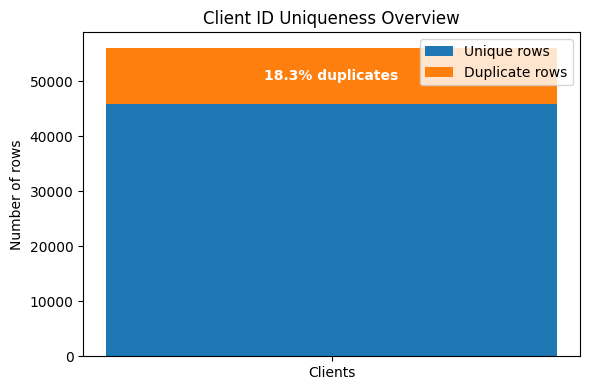

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Total rows
total_rows = len(df_final)

# Identify duplicates based on client_id
duplicate_mask = df_final.duplicated(subset="client_id", keep="first")

duplicate_rows = duplicate_mask.sum()
unique_rows = total_rows - duplicate_rows

duplicate_rate = duplicate_rows / total_rows * 100
print(f"Total Rows: {total_rows}")

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    ["Clients"],
    [unique_rows],
    label="Unique rows"
)

ax.bar(
    ["Clients"],
    [duplicate_rows],
    bottom=[unique_rows],
    label="Duplicate rows"
)

# Labels & title
ax.set_ylabel("Number of rows")
ax.set_title("Client ID Uniqueness Overview")

# Annotate duplicate rate
ax.text(
    0,
    unique_rows + duplicate_rows / 2,
    f"{duplicate_rate:.1f}% duplicates",
    ha="center",
    va="center",
    color="white",
    fontweight="bold"
)

ax.legend()
plt.tight_layout()
plt.show()


  variation  duplicate_rows  total_rows  unique_rows  duplicate_rate
0   control            6210       28072        21862       22.121687
1      test            4037       28041        24004       14.396776


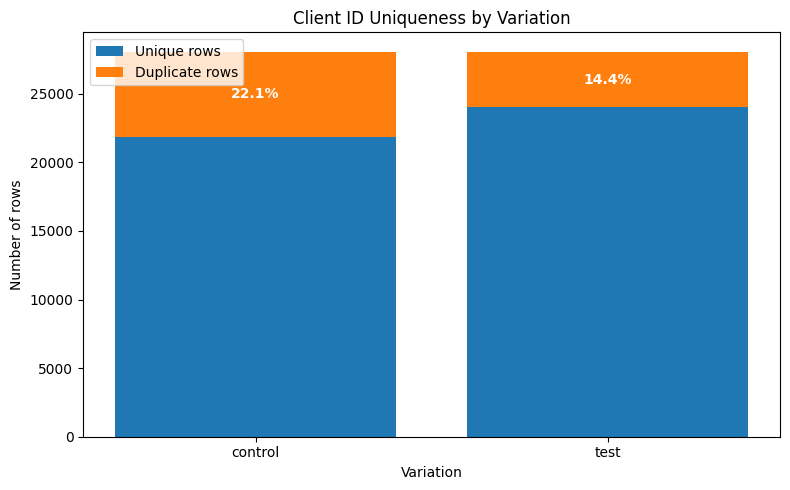

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: df_final has columns 'client_id' and 'variation'
# 'variation' could be 'A', 'B', etc.

# Identify duplicates based on client_id
df_final['is_duplicate'] = df_final.duplicated(subset='client_id', keep='first')

# Group by variation and count unique/duplicate rows
summary = df_final.groupby('variation')['is_duplicate'].agg(
    duplicate_rows='sum',
    total_rows='count'
).reset_index()

summary['unique_rows'] = summary['total_rows'] - summary['duplicate_rows']
summary['duplicate_rate'] = summary['duplicate_rows'] / summary['total_rows'] * 100

print(summary)

# Create stacked bar chart per variation
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    summary['variation'],
    summary['unique_rows'],
    label='Unique rows'
)

ax.bar(
    summary['variation'],
    summary['duplicate_rows'],
    bottom=summary['unique_rows'],
    label='Duplicate rows'
)

# Labels & title
ax.set_ylabel("Number of rows")
ax.set_xlabel("Variation")
ax.set_title("Client ID Uniqueness by Variation")
ax.legend()

# Annotate duplicate rate on each bar
for i, row in summary.iterrows():
    ax.text(
        i,
        row['unique_rows'] + row['duplicate_rows']/2,
        f"{row['duplicate_rate']:.1f}%",
        ha='center',
        va='center',
        color='white',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


#### Tenura analysis
- H0: Mean tenure is the same between control and test.
- Welch two-sample t-test indicates a statistically significant difference in mean tenure between control and test (p = 0.0247).
- The estimated difference is small (~0.14 years, ~1.7 months), suggesting statistical but limited practical significance

In [ ]:
df_final["client_id"].is_unique

False

In [ ]:
n_rows = len(df_final)
n_unique_clients = df_final["client_id"].nunique()

print(f"Rows: {n_rows:,}")
print(f"Unique clients: {n_unique_clients:,}")
print(f"Duplicate rows: {n_rows - n_unique_clients:,}")

dup_rate = (56113 - 45866) / 56113
print(f"Duplicate rate: {dup_rate:.1%}")

Rows: 56,113
Unique clients: 45,866
Duplicate rows: 10,247
Duplicate rate: 18.3%


Overall tenure summary:


,n_clients,mean_tenure_yr,median_tenure_yr,p25_tenure_yr,p75_tenure_yr,min_tenure_yr,max_tenure_yr,std_tenure_yr
0,45866,11.980116,11.0,6.0,15.0,2.0,55.0,6.828493


Number of unique clients: 45866


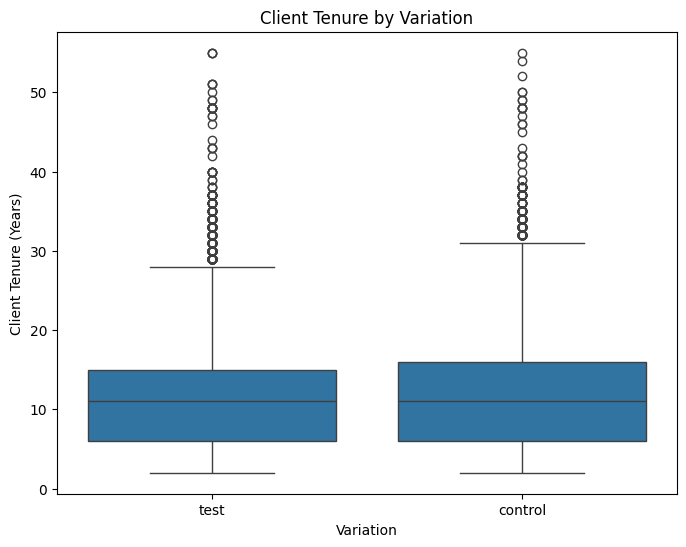

Summary by variation:


,n_clients,mean_tenure,median_tenure,std_tenure
variation,,,,
control,21862,12.055210,11.0,6.859928
test,24004,11.911723,11.0,6.799158


Variance of clnt_tenure_yr by variation:
variation
control    47.058614
test       46.228552
Name: clnt_tenure_yr, dtype: float64

Levene test results:
  Statistic: 1.984
  P-value: 0.1590

Welch t-test results:
  T-statistic: 2.247
  P-value: 0.0247

Mean difference: 0.143 years (~1.7 months)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Deduplicate to one row per client (max tenure)
df_unique = (
    df_final
    .groupby("client_id", as_index=False)
    .agg(clnt_tenure_yr=("clnt_tenure_yr", "max"))
)

assert len(df_unique) == df_final["client_id"].nunique()

# 2. Overall summary statistics
summary_stats = pd.DataFrame({
    "n_clients": [df_unique["clnt_tenure_yr"].count()],
    "mean_tenure_yr": [df_unique["clnt_tenure_yr"].mean()],
    "median_tenure_yr": [df_unique["clnt_tenure_yr"].median()],
    "p25_tenure_yr": [df_unique["clnt_tenure_yr"].quantile(0.25)],
    "p75_tenure_yr": [df_unique["clnt_tenure_yr"].quantile(0.75)],
    "min_tenure_yr": [df_unique["clnt_tenure_yr"].min()],
    "max_tenure_yr": [df_unique["clnt_tenure_yr"].max()],
    "std_tenure_yr": [df_unique["clnt_tenure_yr"].std()]
})

print("Overall tenure summary:")
display(summary_stats)

# 3. First occurrence per client (experiment dataset)
df_first = df_final.drop_duplicates(
    subset="client_id",
    keep="first"
)

print(f"Number of unique clients: {len(df_first)}")

df_first.to_csv("ab_test_unique_clients.csv", index=False)

# 4. Boxplot: tenure by variation
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_first,
    x="variation",
    y="clnt_tenure_yr"
)
plt.title("Client Tenure by Variation")
plt.xlabel("Variation")
plt.ylabel("Client Tenure (Years)")
plt.show()

# 5. Summary statistics by variation
summary_by_variation = (
    df_first
    .groupby("variation")["clnt_tenure_yr"]
    .agg(
        n_clients="count",
        mean_tenure="mean",
        median_tenure="median",
        std_tenure="std"
    )
)

print("Summary by variation:")
display(summary_by_variation)

# 6. Variance by variation
tenure_var_by_variation = (
    df_first
    .groupby("variation")["clnt_tenure_yr"]
    .var()
)

print("Variance of clnt_tenure_yr by variation:")
print(tenure_var_by_variation)

# 7. Levene test (variance equality)
tenure_control = df_first.loc[df_first["variation"] == "control", "clnt_tenure_yr"]
tenure_test    = df_first.loc[df_first["variation"] == "test", "clnt_tenure_yr"]

levene_stat, levene_p = stats.levene(
    tenure_control,
    tenure_test,
    center="median"
)

print("\nLevene test results:")
print(f"  Statistic: {levene_stat:.3f}")
print(f"  P-value: {levene_p:.4f}")

# 8. Welch two-sample t-test
t_stat, p_value = stats.ttest_ind(
    tenure_control,
    tenure_test,
    equal_var=False
)

print("\nWelch t-test results:")
print(f"  T-statistic: {t_stat:.3f}")
print(f"  P-value: {p_value:.4f}")

# 9. Mean difference (effect size intuition)
mean_by_variation = df_first.groupby("variation")["clnt_tenure_yr"].mean()

diff = mean_by_variation["control"] - mean_by_variation["test"]

print(f"\nMean difference: {diff:.3f} years (~{diff * 12:.1f} months)")
